In [1]:
#Nessesary libs
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import tensorflow as tf
from pathlib import Path
from tensorflow.keras import applications
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import optimizers
from tensorflow.keras import metrics
from tensorflow.keras import Model
from tensorflow.keras.applications import resnet
from tensorflow.keras.applications import EfficientNetV2B0

target_shape = (200, 200)

2023-06-03 12:29:10.093672: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-03 12:29:10.725536: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-06-03 12:29:10.725671: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-06-03 12:29:10.725676: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

In [2]:
cache_dir = Path(Path.home()) / ".keras"
anchor_images_path = cache_dir / "left"
positive_images_path = cache_dir / "right"
cache_dir

PosixPath('/home/bartlomiej/.keras')

In [3]:
!pip install --upgrade --no-cache-dir gdown
!gdown 1jvkbTr_giSP3Ru8OwGNCg6B4PvVbcO34
!gdown 1EzBZUb_mh_Dp_FKD0P4XiYYSd0QBH5zW
!unzip -oq left.zip -d $cache_dir
!unzip -oq right.zip -d $cache_dir

Downloading...
From (uriginal): https://drive.google.com/uc?id=1jvkbTr_giSP3Ru8OwGNCg6B4PvVbcO34
From (redirected): https://drive.google.com/uc?id=1jvkbTr_giSP3Ru8OwGNCg6B4PvVbcO34&confirm=t&uuid=146c0c1e-d455-496b-b66b-7a5e9984f115
To: /home/bartlomiej/PycharmProjects/pythonProject/left.zip
100%|████████████████████████████████████████| 104M/104M [00:03<00:00, 27.2MB/s]
Downloading...
From (uriginal): https://drive.google.com/uc?id=1EzBZUb_mh_Dp_FKD0P4XiYYSd0QBH5zW
From (redirected): https://drive.google.com/uc?id=1EzBZUb_mh_Dp_FKD0P4XiYYSd0QBH5zW&confirm=t&uuid=5028de98-9f66-42bf-939b-17633d0c2f01
To: /home/bartlomiej/PycharmProjects/pythonProject/right.zip
100%|████████████████████████████████████████| 104M/104M [00:01<00:00, 83.1MB/s]


In [4]:
def preprocess_image(filename):
    image_string = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image_string, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, target_shape)
    return image


def preprocess_pair(pair, label):
    return ((
        preprocess_image(pair[0]),
        preprocess_image(pair[1]),
    ),label)

In [5]:
anchor_images = sorted(
    [str(anchor_images_path / f) for f in os.listdir(anchor_images_path)]
)

positive_images = sorted(
    [str(positive_images_path / f) for f in os.listdir(positive_images_path)]
)

image_count = len(anchor_images)


anchors = anchor_images * 3
negative_images = anchor_images + positive_images
np.random.RandomState(seed=32).shuffle(negative_images)
labels  = tf.constant([1]*6016 + [0]*12032)

comps = positive_images + negative_images

#input_imgs = tf.stack([img_1, img_2], axis=0)
dataset = tf.data.Dataset.from_tensor_slices(((anchors, comps), labels))
dataset = dataset.shuffle(buffer_size=20000)
dataset = dataset.map(preprocess_pair)

train_dataset = dataset.take(round(image_count * 0.8))
val_dataset = dataset.skip(round(image_count * 0.8))

train_dataset = train_dataset.batch(8, drop_remainder=False)
train_dataset = train_dataset.prefetch(8)

val_dataset = val_dataset.batch(32, drop_remainder=False)
val_dataset = val_dataset.prefetch(8)

2023-06-03 12:29:22.512750: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-03 12:29:22.518521: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-03 12:29:22.518638: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-03 12:29:22.519122: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorF

In [6]:

import matplotlib.pyplot as plt
ex = next(dataset.batch(60).as_numpy_iterator())
# ex = next(dataset.random(60).as_numpy_iterator())

[1 0 1 0 0]


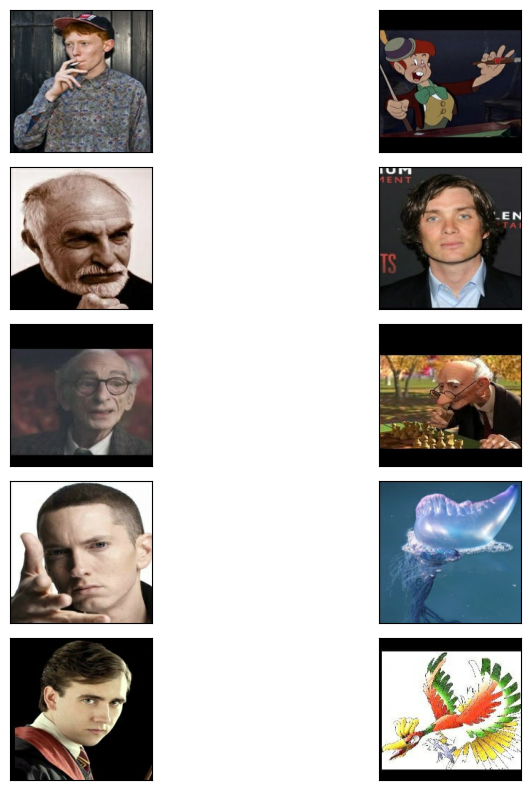

In [7]:
ex0 = ex[0][0]
ex1 = ex[0][1]

print(ex[1][:5])
fig, axes = plt.subplots(5, 2, figsize=(10, 8))
# Iterate through subplots and display images
for i, ax in enumerate(axes):
    ax[0].imshow(ex0[i])
    ax[0].get_xaxis().set_visible(False)
    ax[0].get_yaxis().set_visible(False)
    ax[1].imshow(ex1[i])
    ax[1].get_xaxis().set_visible(False)
    ax[1].get_yaxis().set_visible(False)
plt.tight_layout()
# plt.show()

# Architektura

In [9]:
from keras.layers import Dense, Concatenate, Reshape, Input, Conv2D, ReLU, BatchNormalization, GlobalAveragePooling2D
from keras.applications import EfficientNetV2B0
from keras.utils import plot_model
transfer_layer_size = 512

base_cnn = EfficientNetV2B0(
    weights="imagenet", input_shape=target_shape + (3,), include_top=False
)
# for layer in base_cnn.layers:
#     layer.trainable = False
flatten = layers.Flatten()(base_cnn.output)
dense1 = layers.Dense(1024, activation="relu")(flatten)
dense1 = layers.BatchNormalization()(dense1)
dense2 = layers.Dense(1024, activation="relu")(dense1)
dense2 = layers.BatchNormalization()(dense2)
output = layers.Dense(transfer_layer_size)(dense2)



embedding = Model(inputs = base_cnn.input, outputs = output, name="Embedding")
# embedding.summary()
# plot_model(embedding, 'model.png')


img_input_1 = Input(target_shape + (3,), name="input_image_1")
img_input_2 = Input(target_shape + (3,), name="input_image_2")

feature_vector_A = embedding(img_input_1)
feature_vector_B = embedding(img_input_2)

joint_vector = Concatenate()([feature_vector_A, feature_vector_B])
siamese_dense_1 = Dense(transfer_layer_size*2, activation='relu', name='siamese_dense_1')(joint_vector)
siamese_dense_2 = Dense(1024, activation='relu', name='siamese_dense_2')(siamese_dense_1)
siamese_dense_3 = Dense(512, activation='relu', name='siamese_dense_3')(siamese_dense_2)
siamese_dense_4 = Dense(128, activation='relu', name='siamese_dense_4')(siamese_dense_3)
siamese_dense_5 = Dense(64, activation='relu', name='siamese_dense_6')(siamese_dense_4)
siamese_output = Dense(1, activation='sigmoid', name='siamese_output')(siamese_dense_5)

model = Model(inputs = [img_input_1, img_input_2], outputs = siamese_output)
# model.summary()
# plot_model(model, 'syjam.png')

# FIT

In [10]:
model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])
from keras.callbacks import EarlyStopping
es = EarlyStopping(patience=3)

In [11]:
model.fit(train_dataset, epochs=40, validation_data=val_dataset, callbacks=[es])

Epoch 1/40


2023-06-03 12:29:56.900436: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_1/Embedding/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2023-06-03 12:29:58.978320: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8101
2023-06-03 12:29:59.098084: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-06-03 12:29:59.337806: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7f9e0800fd70 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-06-03 12:29:59.337829: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce GTX 1080, Compute Capability 6.1
2023-06-03 12:29:59.341736: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash

602/602 [==============================] - 135s 181ms/step - loss: 0.6660 - accuracy: 0.6516 - val_loss: 0.6513 - val_accuracy: 0.6670
Epoch 2/40
602/602 [==============================] - 109s 181ms/step - loss: 0.6427 - accuracy: 0.6661 - val_loss: 2.0085 - val_accuracy: 0.6649
Epoch 3/40
602/602 [==============================] - 108s 179ms/step - loss: 0.6455 - accuracy: 0.6709 - val_loss: 0.6377 - val_accuracy: 0.6654
Epoch 4/40
602/602 [==============================] - 107s 179ms/step - loss: 0.6360 - accuracy: 0.6715 - val_loss: 0.6374 - val_accuracy: 0.6656
Epoch 5/40
602/602 [==============================] - 109s 180ms/step - loss: 0.6351 - accuracy: 0.6692 - val_loss: 0.6357 - val_accuracy: 0.6679
Epoch 6/40
602/602 [==============================] - 108s 179ms/step - loss: 0.6360 - accuracy: 0.6674 - val_loss: 0.6382 - val_accuracy: 0.6654
Epoch 7/40
602/602 [==============================] - 107s 177ms/step - loss: 0.6371 - accuracy: 0.6667 - val_loss: 0.6368 - val_accura

In [ ]:
for layer in embedding.layers:
    layer.trainable = True